## Components of EDA
    1.Data Analysis
    2.Feature Engineering
    3.Feature Selection

## Importing Libraries

In [103]:
# scientific computing libaries
import pandas as pd
import numpy as np

# data mining libaries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA#, FastICA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, learning_curve
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

#plot libaries
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # to show plots in notebook

# online plotly
#from plotly.plotly import plot, iplot
#plotly.tools.set_credentials_file(username='XXXXXXXXXXXXXXX', api_key='XXXXXXXXXXXXXXX')

# offline plotly
from plotly.offline import plot, iplot

# do not show any warnings
import warnings
warnings.filterwarnings('ignore')

SEED = 17 # specify seed for reproducable results
pd.set_option('display.max_columns', None)

In [209]:
df=pd.read_csv('ChurnTrainDataset.csv')
print("The dimension of dataset is :",df.shape)
df.head()

The dimension of dataset is : (4250, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107.0,area_code_415,no,yes,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,no
1,NJ,137.0,area_code_415,no,no,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,no
2,OH,84.0,area_code_408,yes,no,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,no
3,OK,75.0,area_code_415,yes,no,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,no
4,MA,121.0,area_code_510,no,yes,24.0,218.2,88.0,37.09,348.5,108.0,29.62,212.6,118.0,9.57,7.5,7.0,2.03,3.0,no


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4232 non-null   object 
 1   account_length                 4216 non-null   float64
 2   area_code                      4234 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4237 non-null   object 
 5   number_vmail_messages          4216 non-null   float64
 6   total_day_minutes              4240 non-null   float64
 7   total_day_calls                4248 non-null   float64
 8   total_day_charge               4242 non-null   float64
 9   total_eve_minutes              4215 non-null   float64
 10  total_eve_calls                4233 non-null   float64
 11  total_eve_charge               4242 non-null   float64
 12  total_night_minutes            4248 non-null   f

In [211]:
df.describe(include=["object", "bool"])

,state,area_code,international_plan,voice_mail_plan,churn
count,4232,4234,4250,4237,4228
unique,51,3,2,2,2
top,WV,area_code_415,no,no,no
freq,139,2101,3854,3127,3634


## Data Analysis

In [212]:
# Checking missing values feature name and its percentage
null_values=[features for features in df.columns if df[features].isnull().sum()>1]
for feature in null_values:
    print(feature,np.round(df[feature].isnull().mean(),4), ' % missing value')

state 0.0042  % missing value
account_length 0.008  % missing value
area_code 0.0038  % missing value
voice_mail_plan 0.0031  % missing value
number_vmail_messages 0.008  % missing value
total_day_minutes 0.0024  % missing value
total_day_calls 0.0005  % missing value
total_day_charge 0.0019  % missing value
total_eve_minutes 0.0082  % missing value
total_eve_calls 0.004  % missing value
total_eve_charge 0.0019  % missing value
total_night_minutes 0.0005  % missing value
total_night_calls 0.0012  % missing value
total_night_charge 0.0016  % missing value
total_intl_minutes 0.0012  % missing value
total_intl_calls 0.0031  % missing value
total_intl_charge 0.0071  % missing value
number_customer_service_calls 0.0007  % missing value
churn 0.0052  % missing value


In [213]:
def preprocess_data(data):
    pre_df = df.copy()
    
    # Replace the spaces in the column names with underscores
    pre_df.columns = [s.replace(" ", "_") for s in pre_df.columns]
    
    # convert string columns to integers
    pre_df["international_plan"] = pre_df["international_plan"].apply(lambda x: 0 if x=="no" else 1)
    pre_df["voice_mail_plan"] = pre_df["voice_mail_plan"].apply(lambda x: 0 if x=="no" else 1)
    le = LabelEncoder()
    le.fit(pre_df[['churn']])
    pre_df['churn'] = le.transform(pre_df['churn'])
    
    return pre_df

In [214]:
pre_df = preprocess_data(df)

#### First, we will check the balance of the target data

In [215]:
pre_df["churn"].value_counts(normalize=True)

0    0.855059
1    0.139765
2    0.005176
Name: churn, dtype: float64

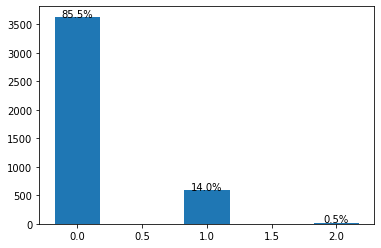

In [216]:
fig, ax = plt.subplots()

pps = ax.bar(pre_df['churn'].value_counts().index,pre_df['churn'].value_counts().values, width=0.35, align='center')

for p in pps:
    height = p.get_height()
    ax.text(x=p.get_x() + p.get_width() / 2, y=height+.10,s='{:.1f}%'.format(100 * p.get_height()/len(pre_df['churn'])),ha='center')

plt.show()

In [217]:
y_yes = pre_df["churn"][pre_df["churn"]== 1]
print ("Churn Percentage = "+str( (y_yes.shape[0] / pre_df["churn"].shape[0]) * 100 ))

Churn Percentage = 13.976470588235292


### Now, as we see the target data looks imbalance, which will be handled at a later stage

In [218]:
pre_df.isnull().sum()

state                            18
account_length                   34
area_code                        16
international_plan                0
voice_mail_plan                   0
number_vmail_messages            34
total_day_minutes                10
total_day_calls                   2
total_day_charge                  8
total_eve_minutes                35
total_eve_calls                  17
total_eve_charge                  8
total_night_minutes               2
total_night_calls                 5
total_night_charge                7
total_intl_minutes                5
total_intl_calls                 13
total_intl_charge                30
number_customer_service_calls     3
churn                             0
dtype: int64

In [219]:
numerical_features=[feature for feature in pre_df.columns if pre_df[feature].dtypes != 'O']
print("Number of numerical variables: ", len(numerical_features))
pre_df[numerical_features].head()

Number of numerical variables:  18


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107.0,0,1,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,0
1,137.0,0,0,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,0
2,84.0,1,0,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,0
3,75.0,1,0,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,0
4,121.0,0,1,24.0,218.2,88.0,37.09,348.5,108.0,29.62,212.6,118.0,9.57,7.5,7.0,2.03,3.0,0


In [222]:
pre_df['state']=pre_df['state'].astype('category').cat.codes
pre_df['area_code']=pre_df['area_code'].astype('category').cat.codes
pre_df['area_code'].values

array([1, 1, 0, ..., 0, 0, 1], dtype=int8)

In [234]:
def impute_null(data):
    for col in data.columns:
        if data[col].dtype != 'O':
            data[col]=data[col].fillna(data[col].median)
        elif data[col].dtype == 'O' or data[col].dtype == 'str':
            data[col]=data[col].fillna(data[col].mode)
        else:
            print("Change the data type of column")
    return data

In [235]:
pre_df=impute_null(pre_df)

In [223]:
def detect_outliers(data,col,method='Quartile'):
    col_data=data[col]
    if method=='Quartile':
        up=data[col].quantile(0.75)+1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))
        low=data[col].quantile(0.25)-1.5*(data[col].quantile(0.75)-data[col].quantile(0.25))    
    elif method=='Standard Deviation':
        up_lim=data[col].mean()+2*data[col].std()
        low_lim=data[col].mean()-2*data[col].std()
    else:
        print('Pass a correct Strategy')
        
    return data

In [224]:
import scipy.stats as sci
def odt_plots(data, col):
    f,ax2=plt.subplots(1,1,figsize=(10,5))
    #Ploting histogram with outlier
    
    sns.distplot(data[col],ax=ax2,color='r',fit=sci.norm)
    ax2.axvline(data[col].mean(),color='g')
    ax2.axvline(data[col].median(),color='b')
    ax2.set_title(col+' '+'Distribution with outliers')
    ax2.set_xlabel('Density')
    ax2.set_ylabel('Column Values')

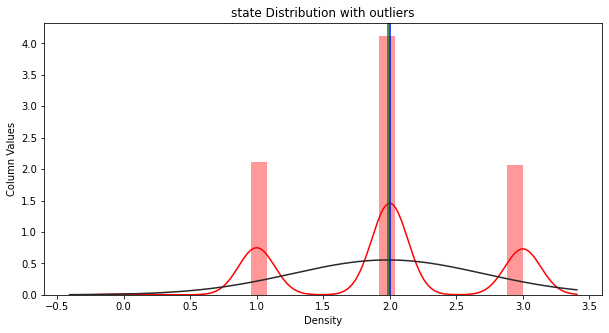

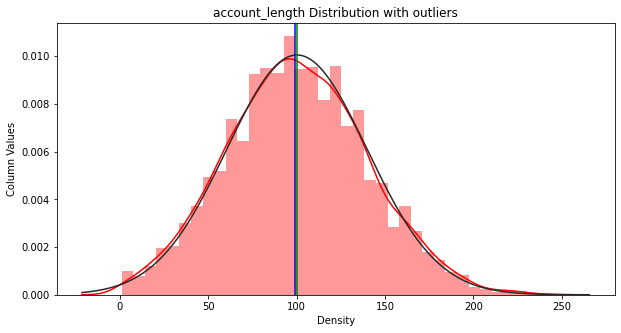

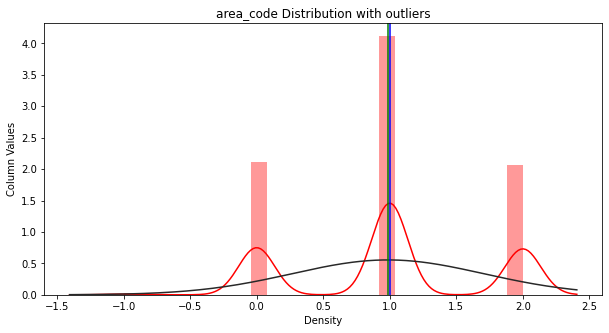

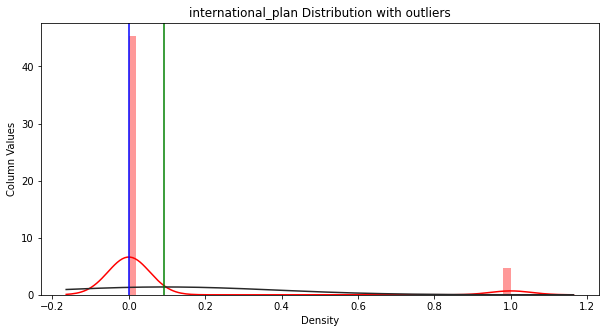

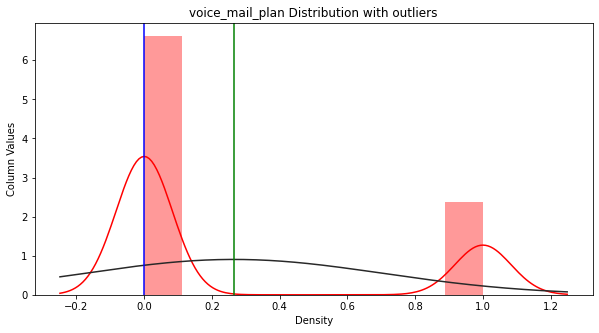

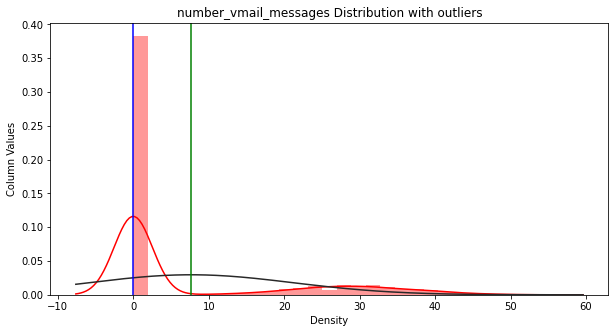

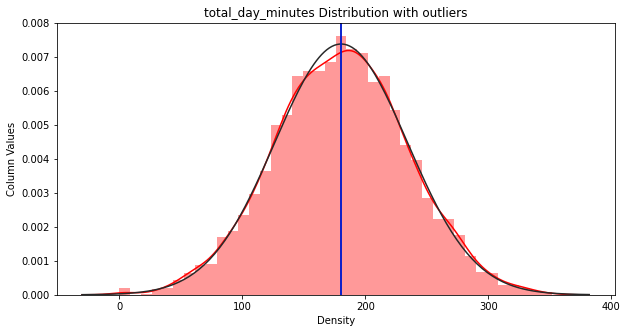

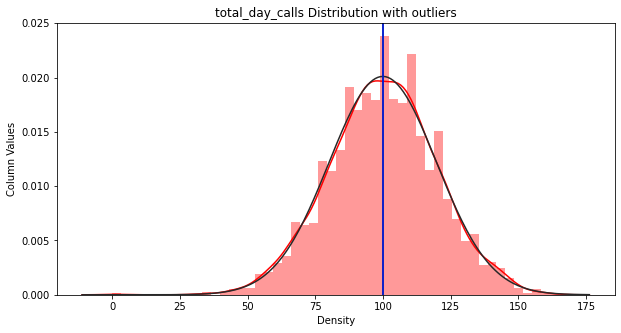

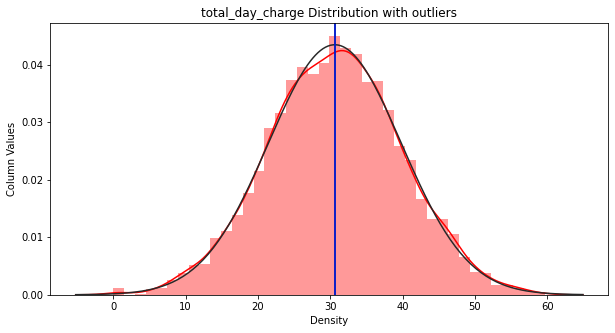

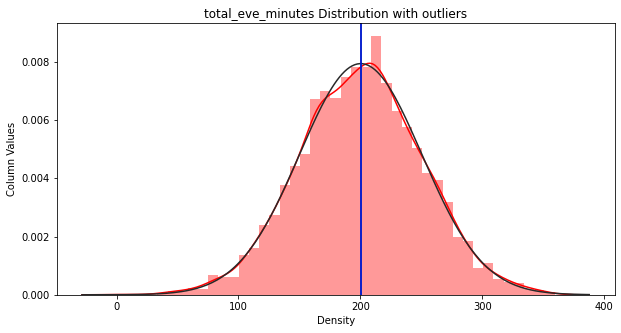

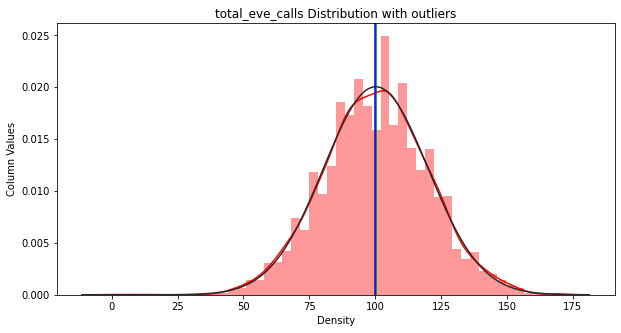

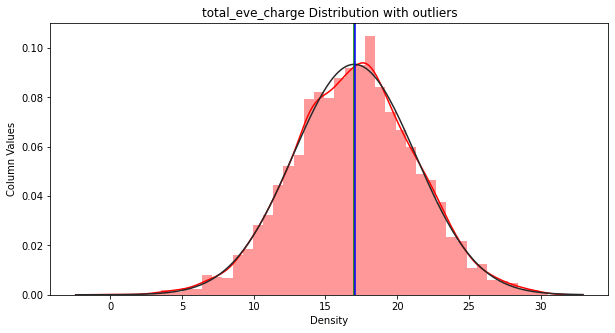

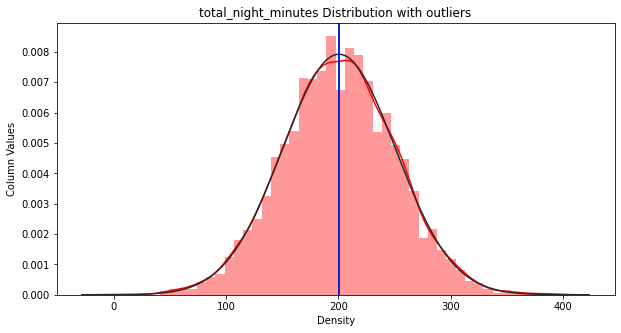

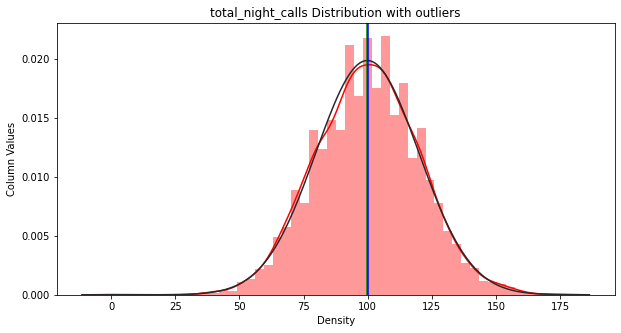

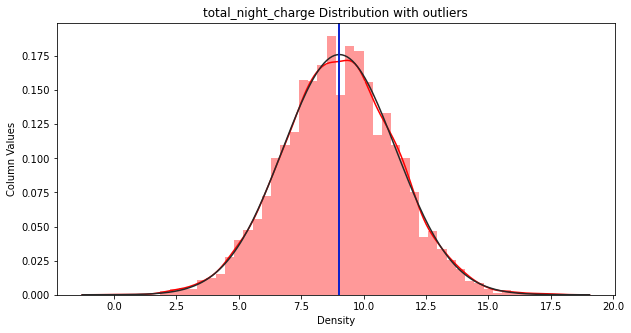

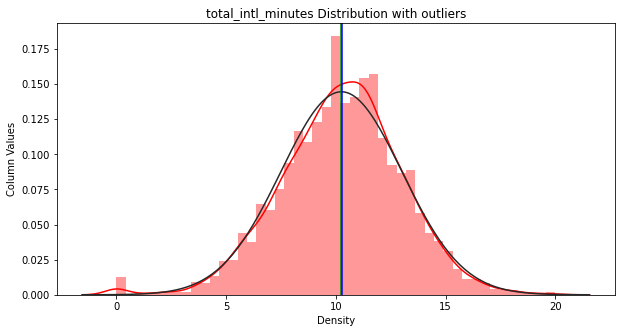

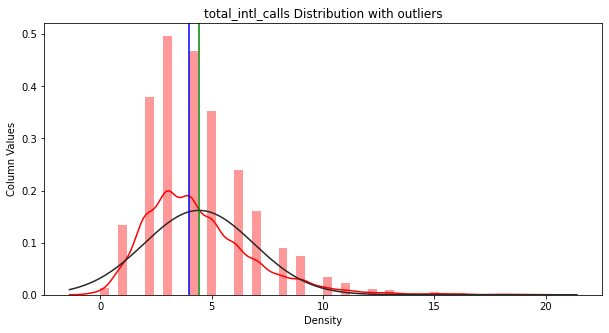

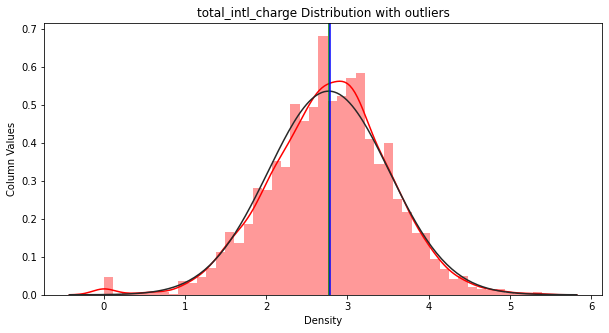

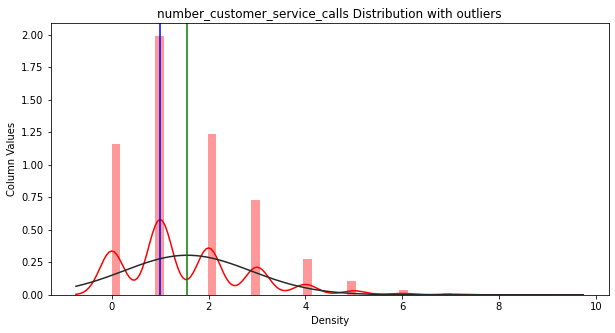

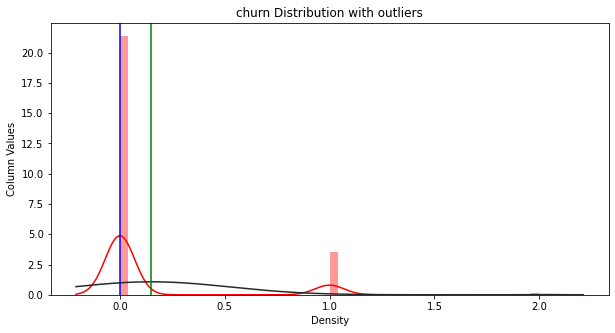

In [225]:
for col in pre_df.columns:
    odt_plots(pre_df,col)

In [226]:
pre_df[pre_df["churn"] == 1].mean()

state                              1.998316
account_length                   102.307823
area_code                          0.998316
international_plan                 0.281145
voice_mail_plan                    0.139731
number_vmail_messages              4.315254
total_day_minutes                208.929561
total_day_calls                  100.510961
total_day_charge                  35.495690
total_eve_minutes                210.031463
total_eve_calls                   99.967742
total_eve_charge                  17.833642
total_night_minutes              206.135919
total_night_calls                 99.194257
total_night_charge                 9.272530
total_intl_minutes                10.640978
total_intl_calls                   4.208475
total_intl_charge                  2.872078
number_customer_service_calls      2.276094
churn                              1.000000
dtype: float64

## We look at the churn distribution per state, to see how much the state influences our target:

In [228]:
state_churn_df = pre_df.groupby(["state", "churn"]).size().unstack()
colors=['red','green','blue']
trace1 = go.Bar(
    x=state_churn_df.index,
    y=state_churn_df[0],
    marker = dict(color = colors[0]),
    name='no churn'
)
trace2 = go.Bar(
    x=state_churn_df.index,
    y=state_churn_df[1],
    marker = dict(color = colors[1]),
    name='churn'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Churn distribution per state',
    autosize=True,
    barmode='stack',
    margin=go.layout.Margin(l=50, r=50),
    xaxis=dict(
        title='state',
        tickangle=45
    ),
    yaxis=dict(
        title='#samples',
        automargin=True,
    ),
    legend=dict(
        x=0,
        y=1,
    ),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

## The distribution of each feature for customer with churn and for the ones without churn

In [229]:
churn = pre_df[pre_df["churn"] == 1]
no_churn = pre_df[pre_df["churn"] == 0]

In [230]:
def create_churn_trace(col, visible=False):
    return go.Histogram(
        x=churn[col],
        name='churn',
        marker = dict(color = colors[1]),
        visible=visible,
    )

def create_no_churn_trace(col, visible=False):
    return go.Histogram(
        x=no_churn[col],
        name='no churn',
        marker = dict(color = colors[0]),
        visible = visible,
    )

features_not_for_hist = ["state","account_length","churn"]
features_for_hist = [x for x in pre_df.columns if x not in features_not_for_hist]
active_idx = 0
traces_churn = [(create_churn_trace(col) if i != active_idx else create_churn_trace(col, visible=True)) for i, col in enumerate(features_for_hist)]
traces_no_churn = [(create_no_churn_trace(col) if i != active_idx else create_no_churn_trace(col, visible=True)) for i, col in enumerate(features_for_hist)]
data = traces_churn + traces_no_churn

n_features = len(features_for_hist)
steps = []
for i in range(n_features):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],
        label = features_for_hist[i],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    step['args'][1][i + n_features] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = active_idx,
    currentvalue = dict(
        prefix = "Feature: ", 
        xanchor= 'center',
    ),
    pad = {"t": 50},
    steps = steps,
)]

layout = dict(
    sliders=sliders,
    yaxis=dict(
        title='#samples',
        automargin=True,
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig, filename='histogram_slider')

## Plotting box plots for each features

In [231]:
def create_box_churn_trace(col, visible=False):
    return go.Box(
        y=churn[col],
        name='churn',
        marker = dict(color = colors[1]),
        visible=visible,
    )

def create_box_no_churn_trace(col, visible=False):
    return go.Box(
        y=no_churn[col],
        name='no churn',
        marker = dict(color = colors[0]),
        visible = visible,
    )

features_not_for_hist = ["state", "account_length", "churn"]
features_for_hist = [x for x in pre_df.columns if x not in features_not_for_hist]
# remove features with too less distinct values (e.g. binary features), because boxplot does not make any sense for them
features_for_box = [col for col in features_for_hist if len(churn[col].unique())>5]

active_idx = 0
box_traces_churn = [(create_box_churn_trace(col) if i != active_idx else create_box_churn_trace(col, visible=True)) for i, col in enumerate(features_for_box)]
box_traces_no_churn = [(create_box_no_churn_trace(col) if i != active_idx else create_box_no_churn_trace(col, visible=True)) for i, col in enumerate(features_for_box)]
data = box_traces_churn + box_traces_no_churn

n_features = len(features_for_box)
steps = []
for i in range(n_features):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * len(data)],
        label = features_for_box[i],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    step['args'][1][i + n_features] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = active_idx,
    currentvalue = dict(
        prefix = "Feature: ", 
        xanchor= 'center',
    ),
    pad = {"t": 50},
    steps = steps,
    len=1,
)]

layout = dict(
    sliders=sliders,
    yaxis=dict(
        title='value',
        automargin=True,
    ),
    legend=dict(
        x=0,
        y=1,
    ),
)

fig = dict(data=data, layout=layout)

iplot(fig, filename='box_slider')

## Co-relation check

In [232]:
pre_df_corr=pre_df.copy()
corr = pre_df_corr.corr()
trace = go.Heatmap(z=corr.values.tolist(), x=corr.columns, y=corr.columns)
data=[trace]
layout = go.Layout(
    title='Heatmap of pairwise correlation of the columns',
    autosize=False,
    width=850,
    height=700,
    yaxis=go.layout.YAxis(automargin=True),
    xaxis=dict(tickangle=40),
    margin=go.layout.Margin(l=0, r=100, b=100, t=80)
)


fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap1')

### Pairwise correlation with other features by conducting a clustering of the features using agglomerative hierarchical clustering with average linkage

In [233]:
from scipy.cluster import hierarchy as hc
X = np.random.rand(10, 10)
pre_df_corr.drop('state',axis=1,inplace=True)
names = pre_df_corr.columns
inverse_correlation = 1 - abs(pre_df_corr.corr())
fig = ff.create_dendrogram(inverse_correlation.values, orientation='left', labels=names, colorscale=colors, linkagefun=lambda x: hc.linkage(x, 'average'))
fig['layout'].update(dict(
    title="Dendogram of clustering the features according to correlation",
    width=800, 
    height=600,
    margin=go.layout.Margin(l=180, r=50),
    xaxis=dict(
        title='distance',
    ),
    yaxis=dict(
        title='features',
        automargin=True,
    ),
))
iplot(fig, filename='dendrogram_corr_clustering')

In [373]:
duplicate_features = ["total_day_charge", "total_eve_charge", "total_night_charge", "total_intl_charge"]

To prepare the dataset for the following analysis we split it into the target column and the other predictors. In addition, we standardize all features to avoid e.g. higher impact of features with higher absolute values in classifiers which are based on a distance metric.

In [366]:
df_y = pre_df["churn"]
df_X = pre_df.drop(["churn"], axis=1)

In [367]:
# Normalizing data
df_X_normed = (df_X - df_X.mean()) / df_X.std()

## Multivariant Analysis of each columns with respect to target class(strength)

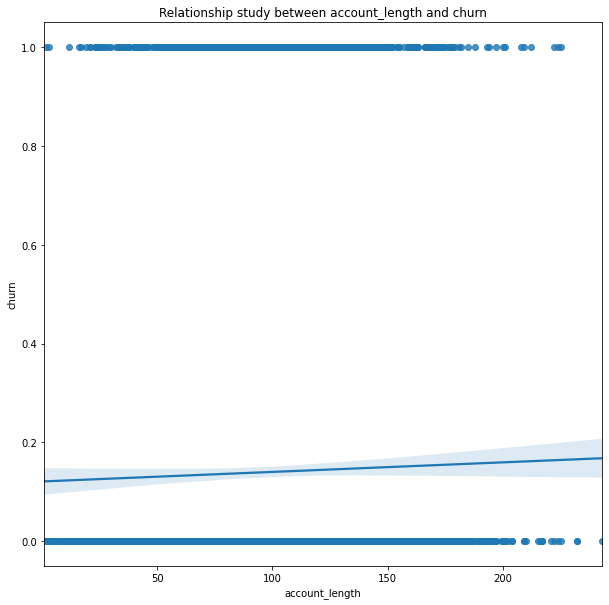

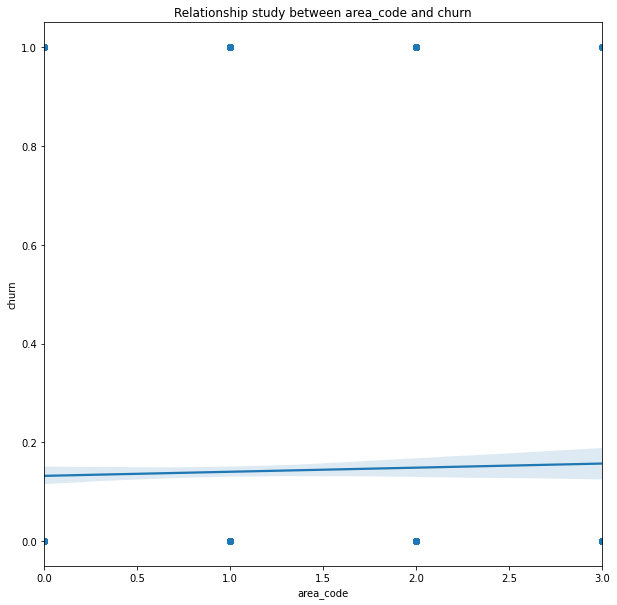

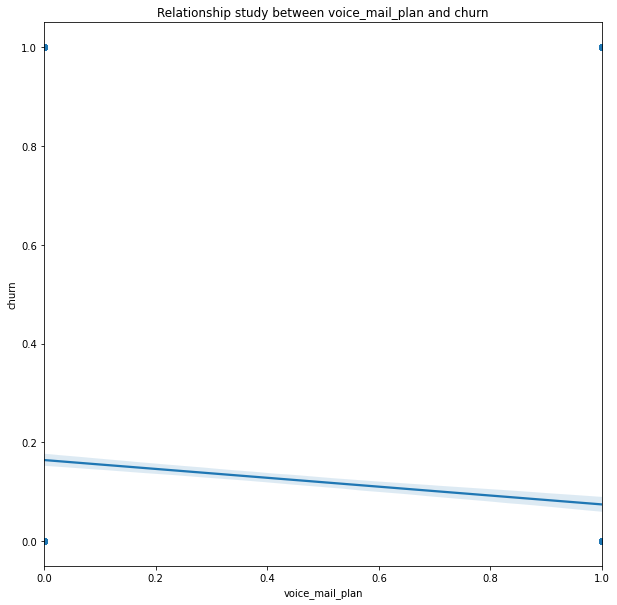

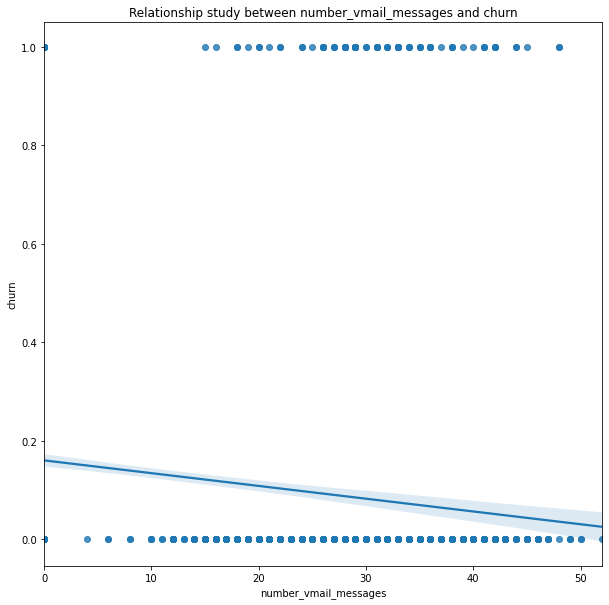

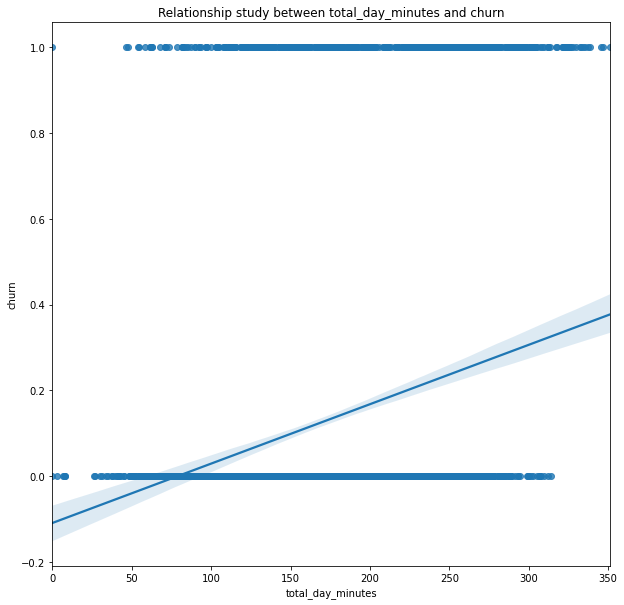

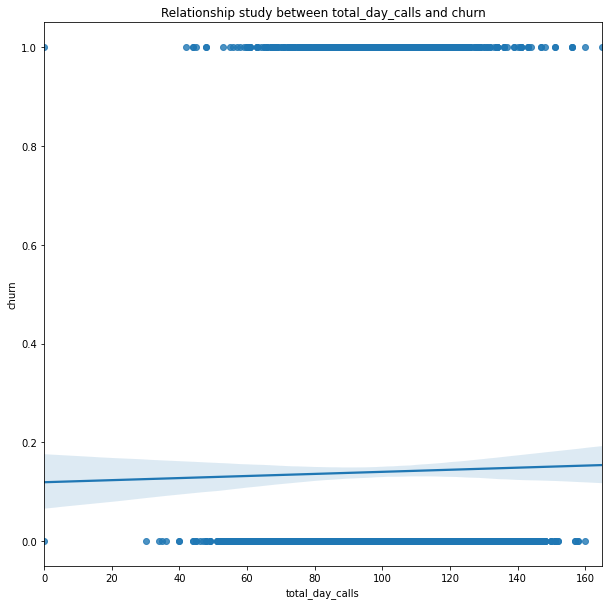

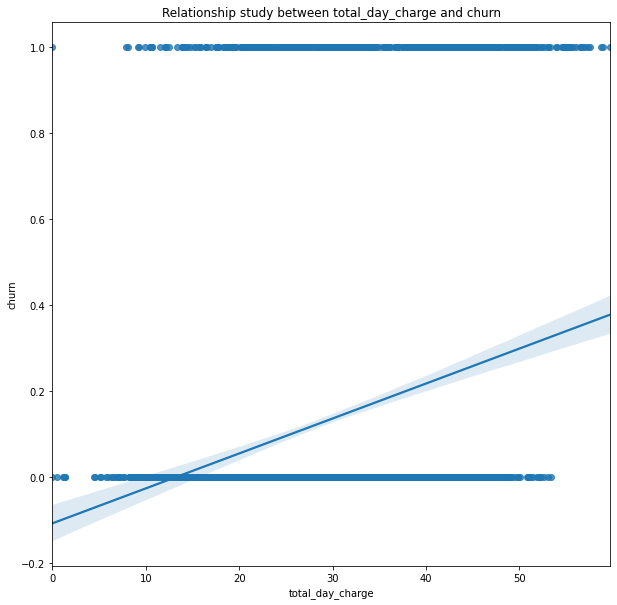

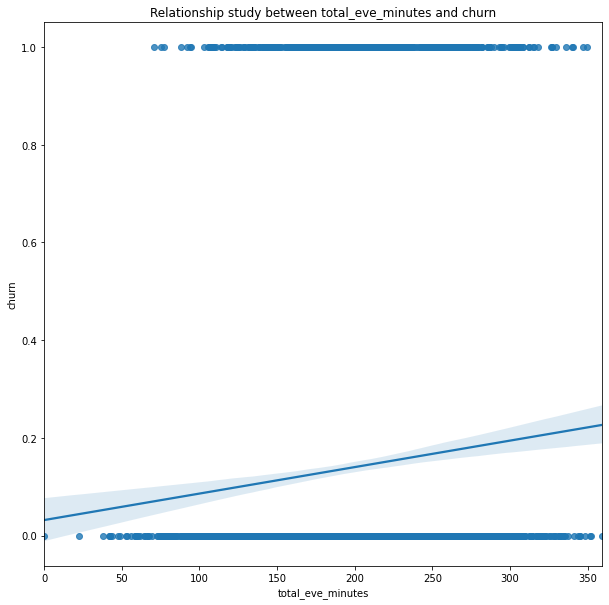

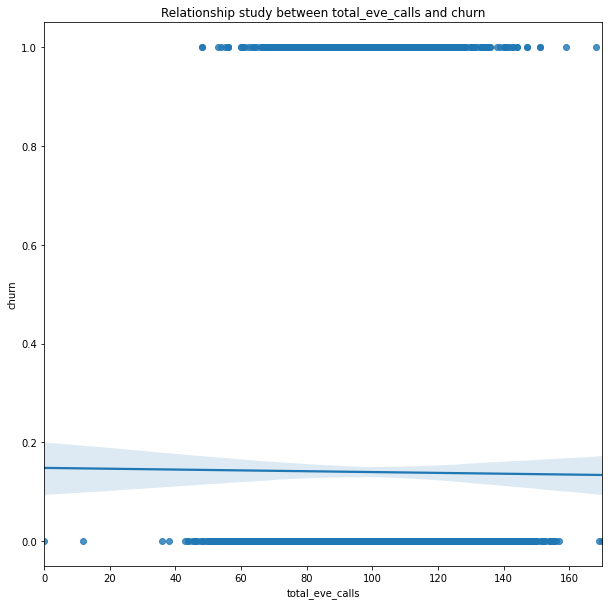

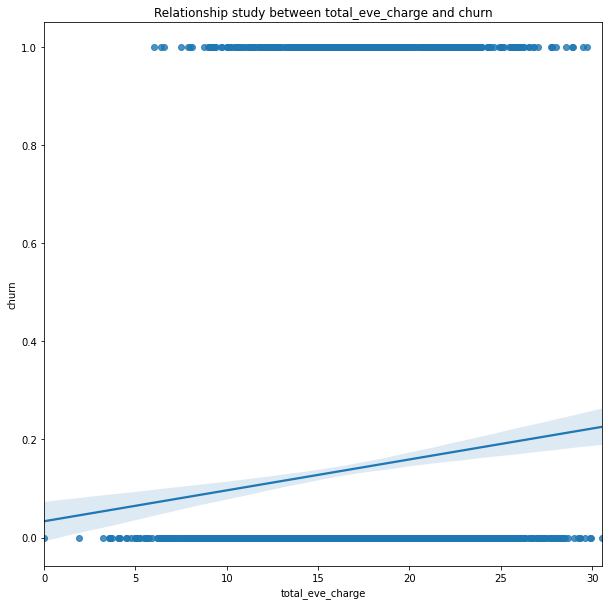

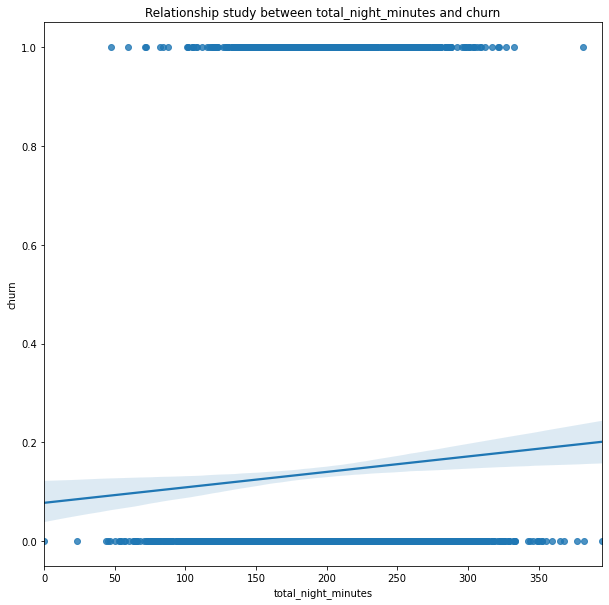

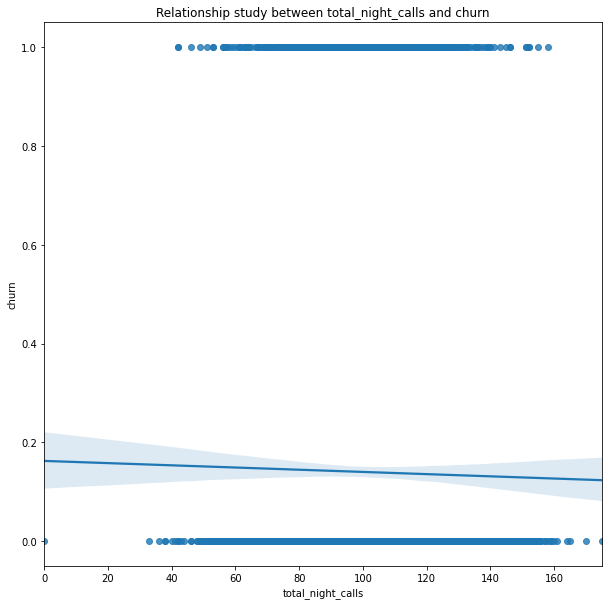

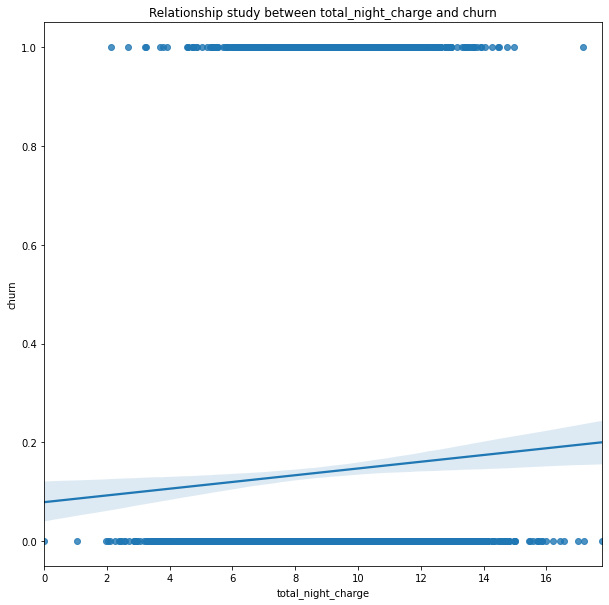

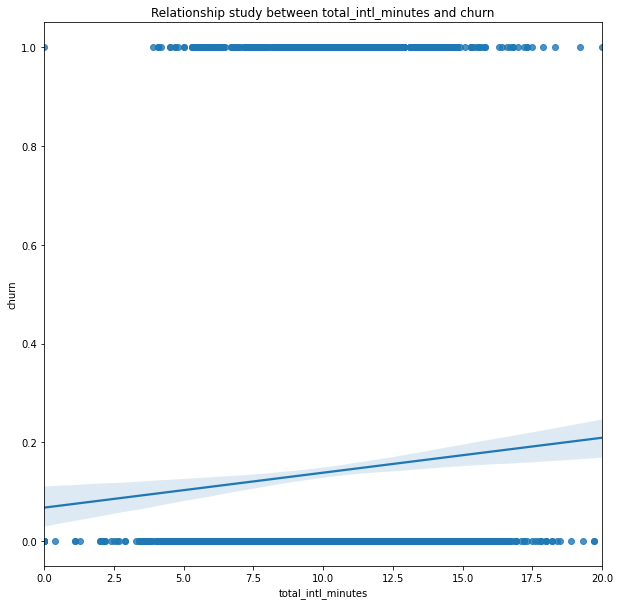

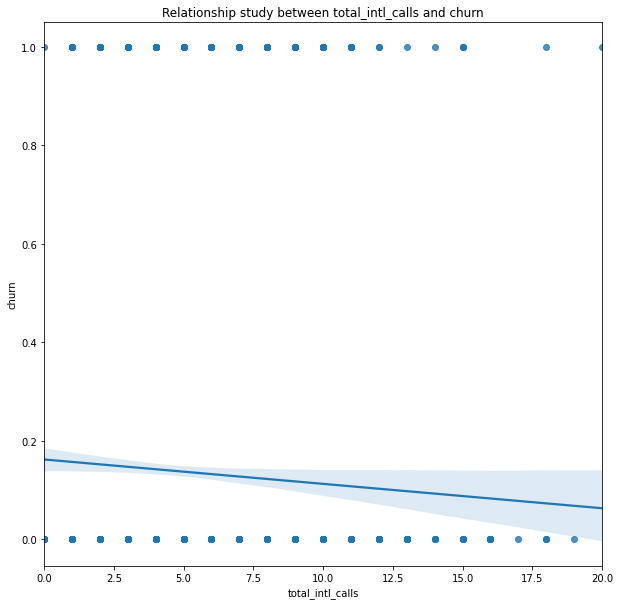

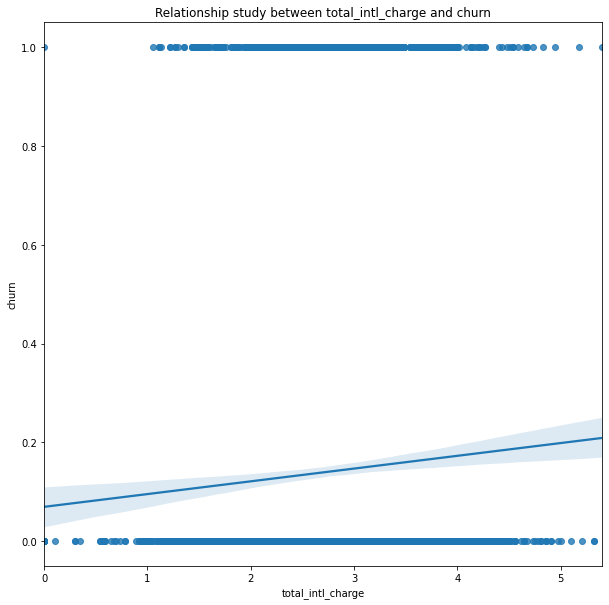

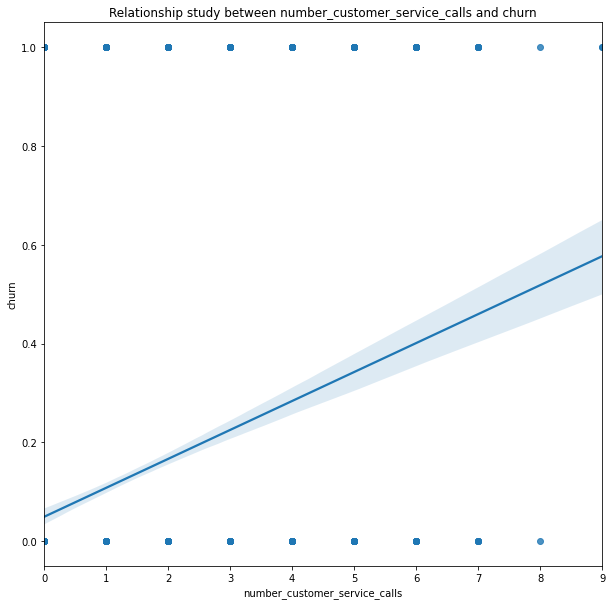

In [375]:
for col in pre_df_corr.columns:
    if col!='churn':
        fig,ax1=plt.subplots(figsize=(10,10),sharex=False)
        sns.regplot(pre_df_corr[col],pre_df_corr['churn'],ax=ax1).set_title(f'Relationship study between {col} and churn')

In [236]:
def correlation_variable(data,tcol):
    x_col=data.drop(columns=tcol).columns
    cor_result=[]
    for col in x_col:
        cor_result.append(data[tcol].corr(data[col]))
    result_df=pd.DataFrame([x_col,cor_result],index=['Variable','Correlation']).T.sort_values('Correlation',ascending=False)
    return result_df

In [238]:
correlation_variable(pre_df,'churn')

,Variable,Correlation
17,number_customer_service_calls,0.221231
5,total_day_minutes,0.214946
7,total_day_charge,0.214453
8,total_eve_minutes,0.07856
10,total_eve_charge,0.077533
14,total_intl_minutes,0.056192
16,total_intl_charge,0.055294
11,total_night_minutes,0.045323
13,total_night_charge,0.044452
1,account_length,0.016425


### VIF factor, It is another method of finding multi colinearity. The formula for VIF is 1/1-r2
    If VIF is more than 5 we say it is multicolinear.

In [383]:
def vif_colinearity(x_col):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif=pd.DataFrame()
    vif['VIF Factor']=[variance_inflation_factor(x_col.values,i) for i in range(x_col.shape[1])]
    vif['Feature']=x_col.columns
    return vif.sort_values('VIF Factor',ascending=False)

In [384]:
vif_colinearity(pre_df_corr.drop(columns='churn'))

,VIF Factor,Feature
12,9366.297225,total_night_charge
10,9363.864841,total_night_minutes
4,3769.077233,total_day_minutes
6,3764.130662,total_day_charge
7,1918.208642,total_eve_minutes
9,1910.254162,total_eve_charge
15,1657.508203,total_intl_charge
13,1648.206223,total_intl_minutes
5,22.009381,total_day_calls
8,21.858344,total_eve_calls


## Missing Data

<AxesSubplot:>

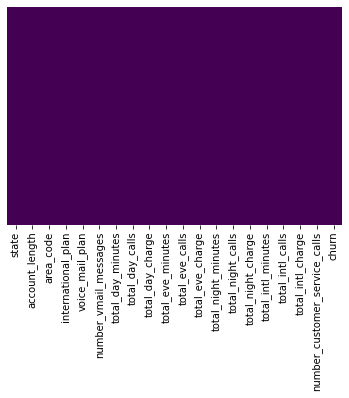

In [238]:
# Using seaborn to create a simple heat map
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")
sns.heatmap(pre_df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

## Here, ends the EDA, we have observed now that there are no missing values and also which features are performing well to the target.